In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import itertools

from multiprocessing import Pool

In [2]:
%run config.py

In [3]:
valid = pd.read_pickle(PATH_VALID_DEVICES, compression='gzip')

# Snapshots per hour

**RQ:** How many snapshots did we collect per hour of the day?

In [4]:
def worker_snapshots_per_hour(uuid):
    df = pd.read_pickle('%s%s.pkl.gz' % (PATH_DEVICES_DIR, uuid), compression='gzip')
    return pd.DataFrame(columns=[h for h in range(0,24)]).append(df.LocalTime.dt.hour.value_counts().sort_index().T, ignore_index=True)

In [5]:
uuids = valid.UUID.tolist()

p = Pool(NUM_CORES)
lst = p.map(worker_snapshots_per_hour, uuids)

hours = pd.concat(lst)
hours = hours.reset_index(drop=True)
hours.tail()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
3948,61,51,40,38,31,32,64,81,92,78,...,77,87,77,75,88,79,84,85,80,75
3949,33,36,34,40,34,41,37,43,42,35,...,40,37,36,32,42,49,44,45,45,42
3950,151,157,154,154,148,149,146,146,152,146,...,159,168,167,172,165,171,162,157,154,147
3951,80,81,74,73,73,72,75,71,71,66,...,74,73,80,83,78,74,76,82,80,86
3952,44,48,46,47,31,29,31,34,29,31,...,44,50,48,50,45,44,44,48,42,43


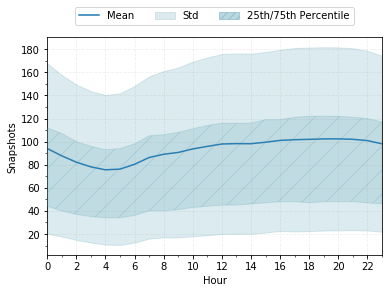

In [6]:
ax = hours.fillna(0).mean(axis=0).plot(
    kind='line',
    xlim=(0, 23),
    xticks=range(0, 24, 1),
    yticks=range(0, 190, 10),
    figsize=(6, 4),
    legend=True,
    grid=True)

# Ticks
ax.set_xticks(range(0, 24, 2))
ax.set_xticks(range(0, 24, 1), minor=True)
ax.set_yticks(range(0, 190, 20))
ax.set_yticks(range(0, 190, 10), minor=True)

# Grid
ax.set_axisbelow(True)
ax.xaxis.grid(alpha=0.2, linestyle='dashed')
ax.yaxis.grid(alpha=0.2, linestyle='dashed')

# Tweak font sizes
ax.set_xlabel('Hour', fontsize=10)
ax.set_ylabel('Snapshots', fontsize=10)
ax.tick_params(labelsize=10)

# Quantiles
ax.fill_between(range(0, 24),
                [hours.fillna(0)[x].quantile(.25) for x in hours.fillna(0).columns],
                [hours.fillna(0)[x].quantile(.75) for x in hours.fillna(0).columns],
                color='#539caf',
                alpha=0.2,
                zorder=100,
                hatch='/')

# Std
ax.fill_between(range(0, 24),
                [hours.fillna(0)[x].mean() - hours.fillna(0)[x].std() for x in hours.fillna(0).columns],
                [hours.fillna(0)[x].mean() + hours.fillna(0)[x].std() for x in hours.fillna(0).columns],
                color='#539caf',
                alpha=0.2)

# Overall mean
#ax.axhline(hours.mean().mean(), color='r', linestyle='--')

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles+[patches.Patch(color='#539caf', alpha=0.2), patches.Patch(color='#539caf', hatch='///', alpha=0.4)],
          labels=['Mean', 'Std', '25th/75th Percentile'],
          loc='center',
          bbox_to_anchor=(0.5, 1.1),
          ncol=3, 
          prop={'size': 10})

plt.savefig('figures/snapshots_per_hour.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.savefig('figures/snapshots_per_hour.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

In [7]:
hours.mean().mean()

93.13721832299193

In [8]:
hours.mean().std()

8.931816134384421